<a href="https://colab.research.google.com/github/AlexanderVinarsky/SIBUR_Case_Computer_Vision/blob/main/Technical_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Решение команды Корделл специально для компании СИБУР**

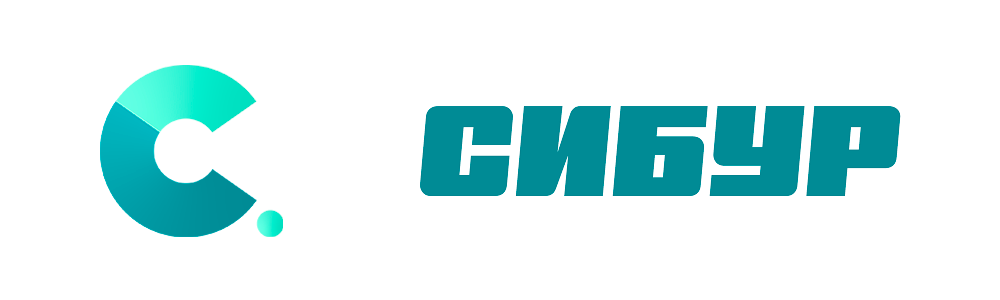

Решение команды Корделл основано на использовании Computer Vision для оптимизации проверки контейнеров на предмет брака.

Типов дефектов много, однако большая часть из них может быть выявлена с помощью Машинного Обучения: например, деформации контейнера, коррозия, нечитаемый текст нумерации контейнера или несовпадение информации нумерации с данными.

Таким образом, пайплайн решения состоит из нескольких моделей машинного обучения:


1.   Распознавание деформаций контейнера
  *   Модель для определения наличия деформации
  *   Модель для определения места, где произошла деформация
2.   Распознавание текста нумерации




# **Распознавание повреждений:**



Импортируем необходимые библиотеки и распакуем архив:

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install 'git+https://github.com/facebookresearch/detectron2'

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

from scipy.spatial import distance

In [ ]:
!unzip containers.zip

In [ ]:
dataDir='/content/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "/content/img"

Инициализация COCO:

In [ ]:
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


Импорт detectron2:

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

plt.rcParams["figure.figsize"] = [16,9]

In [ ]:
!python -m detectron2.utils.collect_env

-------------------------------  ----------------------------------------------------------------
sys.platform                     linux
Python                           3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
numpy                            1.22.4
detectron2                       0.6 @/usr/local/lib/python3.9/dist-packages/detectron2
Compiler                         GCC 9.4
CUDA compiler                    CUDA 11.8
detectron2 arch flags            7.5
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu116 @/usr/local/lib/python3.9/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            Tesla T4 (arch=7.5)
Driver version                   525.85.12
CUDA_HOME                        /usr/local/cuda
Pillow                           8.4.0
torchvision                      0.14.1+cu116 @/usr/local/lib/python3.9/dist-packages/torchvision


In [ ]:
dataset_dir = "/content/val"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("container_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("container_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

AssertionError: ignored

Выполним конфигурацию моделей детектрона:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.RETINANET.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = os.path.join("drive/MyDrive/damage_segmentation_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg['MODEL']['DEVICE']='cuda'
damage_predictor = DefaultPredictor(cfg)

[04/02 12:57:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from drive/MyDrive/damage_segmentation_model.pth ...


  pixel_mean
  pixel_std


In [ ]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 6
cfg_mul.MODEL.WEIGHTS = os.path.join("drive/MyDrive/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg_mul['MODEL']['DEVICE']='cuda'
part_predictor = DefaultPredictor(cfg_mul)

[04/02 12:57:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from drive/MyDrive/part_segmentation_model.pth ...


  pixel_mean
  pixel_std


Создадим класс для определения повреждённых частей контейнера:

In [ ]:
def detect_damage_part(damage_dict, parts_dict):
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]

    return list(set(part_name.values()))
  except Exception as e:
    print(e)

In [ ]:

damage_class_map= {0:'damage'}
parts_class_map={0:'front',1:'back', 2:'door', 3:'top', 4: 'side'}

Протестируем на неповреждённом контейнере:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/val/1.jpg")

damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [ ]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

In [ ]:
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()

parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

**Вывод - контейнер не повреждён:**

In [ ]:
print("Damaged Parts: ",detect_damage_part(damage_dict,parts_dict))

AssertError: damage_dict should have atleast one damage
Damaged Parts:  None


Протестируем на повреждённом контейнере:

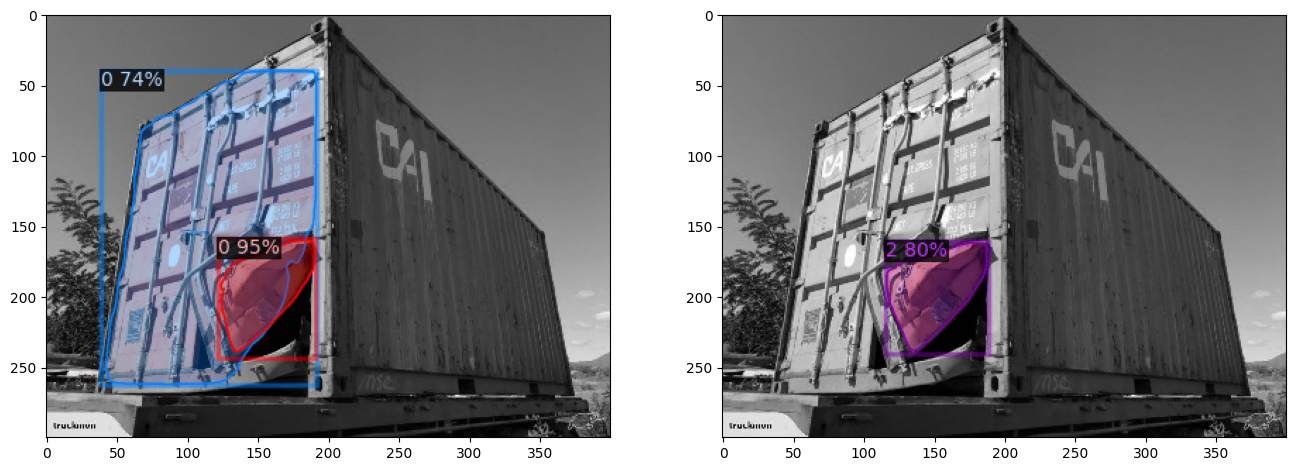

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/val/broken.jpg")

damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("container_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [ ]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

In [ ]:
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()

parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

**Вывод - у контейнера повреждена дверь:**

In [ ]:
print("Damaged Parts: ",detect_damage_part(damage_dict,parts_dict))

AssertError: parts_dict should have atleast one part
Damaged Parts:  None


# **Распознавание текста:**

In [ ]:
!pip install easyocr
import easyocr
reader = easyocr.Reader(["en"])

In [ ]:
result = reader.readtext("/content/val/Container-door.jpg")

In [ ]:
datum=[]
cur = 0
code=''
for i in range(len(result)):
  if (len(result[i][1])==4) and result[i][1].isalpha():
    datum.append(result[i][1])
    cur+=1
    break
for i in range(cur, len(result)):
  if (result[i][1].isdigit()):
    datum.append(result[i][1])
    cur+=1
    break
for i in range(cur, len(result)):
  if (len(result[i][1])==4):
    code+=result[i][1][:2]
    code+='G'
    code+=result[i][1][-1]
    datum.append(code)
    cur+=1
    break


In [ ]:
datum

['MEDU', '248438', '22G1']